In [63]:
import urllib.request
from bs4 import BeautifulSoup as bs
import re
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

In [64]:
class Page:
    
    def __init__(self, myStart, myStop):
        self.start = myStart #myStart is a STRING, representing the name of the start article
        self.stop = myStop #myStop is an INT, reprsenting what tier to stop at
        self.nodes = []
        self.edges = []
        self.scores = {} # correlates with nodes
        self.tiers = {} # correlates with nodes
        self.mainTags = [] # tags of the start article
        self.findAll(myStop)

    def findTags(node):
        myTags = []
        
        response = urllib.request.urlopen('https://en.wikipedia.org/wiki/' + node)
        html = response.read().decode('utf-8')
        seg = re.findall('\<div id="catlinks".*\<div', str(html))[0]
        soup = bs(seg, 'lxml')
        for link in soup.find_all('a', href=True):
            url = link.get('href')
            if(url.startswith('/wiki/Category:')):
                cat = url[15:]
                myTags.append(cat)
        return myTags
    
    def tagScore(node1, node2):
        tags1 = Page.findTags(node1)
        tags2 = Page.findTags(node2)
        intersect = len( [x for x in tags1 if x in tags2] )
        len1 = len( tags1 )
        len2 = len( tags2 )
        score = float(intersect)/((len1 + len2)/2)
        score = int(score*100)
        return score
    
    def findAll(self, n):
        '''
        finds all nodes n branches away from self.start
        @param n is an int
        '''
        tier = 0
        self.nodes.append(self.start)
        self.scores[self.start] = Page.tagScore(str(self),str(self))
        self.tiers[self.start] = str(tier)
        self.findNext(self.start, 0, n)
        self.mainTags = Page.findTags(str(self))
        for string in Page.findTags(self.start):
            for word in string.split('_'):
                self.mainTags.append(word)

    def findNext(self, centerA, tier, n):
        if(tier + 1 < n):
            print('top: ' + str(tier))
            fooNodes = self.findTier(centerA)
            tier += 1
            for s in fooNodes:
                if( s not in self.nodes):
                    self.nodes.append(s)
                    self.scores[s] = Page.tagScore(str(self), s)
                    self.tiers[s] = str(tier)
                    self.edges.append( (s, centerA) )
                    centerA = s
                    print('bottom: ' + str(tier))
                    self.findNext(centerA, tier, n)

    def findTier(self, centerB):
        '''
        finds all nodes 1 branch away from centerB
        @param centerB is a string representing a wikipedia article title
        '''
        nodeList = []
        response = urllib.request.urlopen('https://en.wikipedia.org/wiki/' + centerB)
        html = response.read()
        soup = bs(html,'lxml')
        for par in soup.find_all('p'):
            for link in par.find_all('a', href=True):
                url = link.get('href')
                if(url.startswith('/wiki/')) and (':' not in url):
                    if('#' in url):
                        hashLoc = url.find('#')
                        curSubj = url[6:hashLoc]
                    else:
                        curSubj = url[6:]
                    nodeList.append(curSubj)
        return nodeList
    
    def getNodes(self):
        return self.nodes
    def getEdges(self):
        return self.edges
    def getMainTags(self):
        return self.mainTags
    def getScores(self):
        return self.scores
    def getTiers(self):
        return self.tiers
    
    def __str__(self):
        return self.start

In [65]:
sci = Page('science', 2)

top: 0
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bottom: 1
bot

In [70]:
math = Page('mathematics', 2)

0


In [9]:
lit = Page('literature', 2)

0
literature
Writing
literature
Oral_literature
literature
History_of_printing
literature
Electronic_literature
literature
Fiction
literature
Non-fiction
literature
Poetry
literature
Prose
literature
Novel
literature
Short_story
literature
Drama
literature
Aesthetics
literature
Genre
literature
Western_Europe
literature
Romanticism
literature
Cultural_studies
literature
Western_canon
literature
Value_judgment
literature
Belles-lettres
literature
Encyclop%C3%A6dia_Britannica_Eleventh_Edition
literature
Formalism_(literature)
literature
Journalism
literature
Scientific_literature
literature
Ordinary_language
literature
Etymology
literature
Latin_language
literature
Rhythm
literature
Verse_(poetry)
literature
Sentence_(linguistics)
literature
Line_(poetry)
literature
Syntax
literature
Aristotle
literature
Poetics_(Aristotle)
literature
Literacy
literature
Language
literature
Natural_speech
literature
Ancient_Greece
literature
Classical_antiquity
literature
Performance
literature
Opera
lit

KeyboardInterrupt: 

In [6]:
hist = Page('history', 2)

In [8]:
art = Page('art', 2)

In [9]:
cs = Page('computer_science', 2)

In [66]:
colormap = {'0': 'red', '1':'orange', '2':'green', '3':'blue', '4':'purple'}

def graph(page):
    graph = nx.Graph()
    nodes = page.getNodes()
    edges = page.getEdges()
    scores = page.getScores()
    tiers = page.getTiers()
    for node in nodes:
        graph.add_node(node)
    for node_a, node_b in edges:
        graph.add_edge(node_a, node_b)

    pos=nx.spring_layout(graph)      
    sizes = [scores[node] for node in graph.nodes_iter()]
    colors = [colormap[tiers[node]] for node in graph.nodes_iter()]
    nx.draw_networkx_nodes(graph ,pos, node_size=sizes, alpha=0.8, node_color = colors)
    nx.draw_networkx_edges(graph, pos, width = 0.1, alpha = 0.5)
    fig = plt.gcf()
    fig.savefig(str(page)+'.pdf')

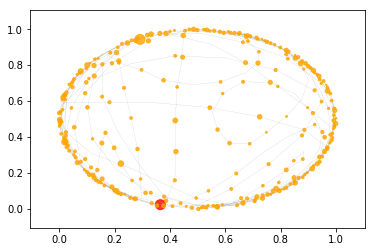

In [67]:
graph(sci)